# Lab 6: Linear Quadratic Regulator

University of California Berkeley

ME C231A, EE C220B, Experiential Advanced Control I  

***

These notes were developed by Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

If you are enrolled in ME C231A/EE C220B you may take notes and make copies of course materials for your own use. You may also share those materials with another student who is registered and enrolled in this course, and with DSP.

You may not reproduce, distribute or display (post/upload) (Links to an external site.) lecture notes or recordings or course materials in any other way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Links to an external site.Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

***

In this lab we will design and implement a receding-horizon linear quadratic regulator for an inverted pendulum system.

# System Description
The inverted pendulum system consists of an inverted pendulum mounted on a cart as shown in the figure.  The objective is to balance the inverted pendulum through the acceleration of the cart.  The dynamics of the inverted pendulum are

\begin{align}
(I + ml^2) \ddot{\theta} + b \dot{\theta} - mgl \sin\theta = ml \cos \theta u.
\end{align}

where $u$ is the cart acceleration, $\theta$ is the pendulum angle and $m$, $l$, and $I$ are the pendulum mass, half-length, and moment of inertia respectively.  See the figure below.

In non-linear state-space form the dynamics are
\begin{align}
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\begin{bmatrix} x_2 \\ -a_0 \sin x_1 - a_1 x_2 \end{bmatrix} +
\begin{bmatrix}0 \\ b_0 u\cos x_1 \end{bmatrix}
\end{align}

where $x_1 = \theta$ and $x_2 = \dot{\theta}$, and $a_0 = -\tfrac{mgl}{I + ml^2}$, $a_1 = \tfrac{b}{I + ml^2}$, and  $b_0 = \tfrac{ml}{I + ml^2}$.  In this lab we will use the parameters: $a_0 = -2.5$, $a_1 = 0.05$, and $b_0 = 0.25$.

In [1]:
from __future__ import division, print_function
import numpy as np

def continuous_dyn(t, x, u, a0, a1, b0):
    theta, thetadot = x
    return [thetadot, - a0*np.sin(theta) - a1*thetadot + b0*u*np.cos(theta)]

def continuous_dyn_with_controller(t, x, Klqr, a0, a1, b0):
    theta, thetadot = x
    k1, k2 = Klqr
    u = -k1*theta-k2*thetadot
    return [thetadot, - a0*np.sin(theta) - a1*thetadot + b0*u*np.cos(theta)]

# Model Construction
We are going to use basic some commands to design a linear discrete-time controller to control the non-linear continuous-time inverted pendulum system.  First we linearize the system dynamics about the equilibrium $\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$ which produces the linearized dynamics

\begin{align}
\begin{bmatrix} \dot{x}_1 \\ \dot{x}_2 \end{bmatrix} =
\underbrace{\begin{bmatrix} 0 & 1 \\ -a_0 & - a_1 \end{bmatrix}}_{A_c}\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} +
\underbrace{\begin{bmatrix}0 \\ b_0 \end{bmatrix}}_{B_c} u.
\end{align}

where $\sin(x_1) \approx x_1$ and $\cos(x_1) \approx 1$. Create the appropriate matrices $\texttt{Ac}$ and $\texttt{Bc}$ in the workspace.
Now we need to convert the continuous-time dynamics to discrete-time. This can be accomplished using the $\texttt{scipy}$ command $\texttt{cont2discrete}$

In [2]:
import scipy.signal
Ts = 0.1       # Ts is the discrete sample-time.
# define the parameters
a0 = -2.5
a1 = 0.05
b0 = 0.25

Ac = np.array([[0, 1],
               [-a0, -a1]])
Bc = np.array([[0],
               [b0]])
# we don't need C and D here. This is just for calling the function
Cc = np.zeros((1,2))
Dc = np.zeros((1,1))
system = (Ac, Bc, Cc, Dc)
Ad, Bd, Cd, Dd, dt = scipy.signal.cont2discrete(system, Ts)

Next use the $\texttt{scipy}$ command $\texttt{solve_discrete_are}$ to create a discrete-time linear quadratic regulator for the discretized system
# Linear Quadratic Regulator

In [3]:
Q = np.diag([1,0])
R = 1

This choice of $Q$ and $R$ represents an infinite-horizon cost of the form
\begin{align}
\sum_{k=0}^{\infty} x_1(k)^2 + u(k)^2
\end{align}

The command to obtain the optimal feedback, $u(k) = -K_{\rm lqr} x(k)$ is below

In [4]:
import scipy.linalg

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check
    eigVals, eigVecs = scipy.linalg.eig(A - B @ K)
    return K, P, eigVals

Klqr, P, eigvals = dlqr(Ad, Bd, Q, R)

Finally we simulate the inverted pendulum system in closed-loop with the controller.  

In [5]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

x0 = np.array([np.pi/4, 0])
Tf = 10
traj_time = np.arange(0.0, Tf, Ts)
t0 = 0.0

sol = solve_ivp(fun=continuous_dyn_with_controller, t_span=[t0, Tf], t_eval=traj_time,
                y0=x0, method='RK45', vectorized=True, args=(Klqr.flatten(), a0, a1, b0))

u = [-Klqr.dot(sol.y[:, i]) for i in range(len(sol.y[0,:]))]

Plot the results of the simulation.

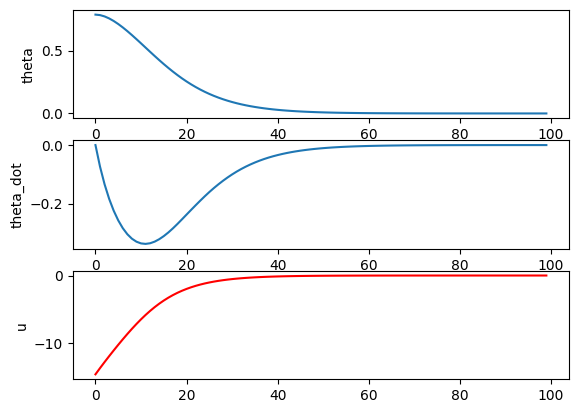

In [6]:
# from matplotlib import rc
# rc('text', usetex=True)
# plt.rc('font', family='serif')

plt.subplot(3,1,1)
plt.plot(sol.y[0,:])
plt.ylabel('theta')
plt.subplot(3,1,2)
plt.plot(sol.y[1,:])
plt.ylabel('theta_dot')
plt.subplot(3,1,3)
plt.plot(u, 'r')
plt.ylabel('u')
plt.show()

Now repeat the simulation with different values of the weighting matrices $\texttt{Q}$ and $\texttt{R}$.
Try
* $\texttt{Q = np.diag([1, 2])}$ and $\texttt{R=1}$
* $\texttt{Q = np.diag([1, 0])}$ and $\texttt{R=1/1000}$
* $\texttt{Q = np.diag([1, 2])}$ and $\texttt{R=1/1000}$

For the cases where $\texttt{R=1/100}$ you may need to extend the simulation time $\texttt{Tf}$. How do the different weighting values change the behavior of the closed-loop system?

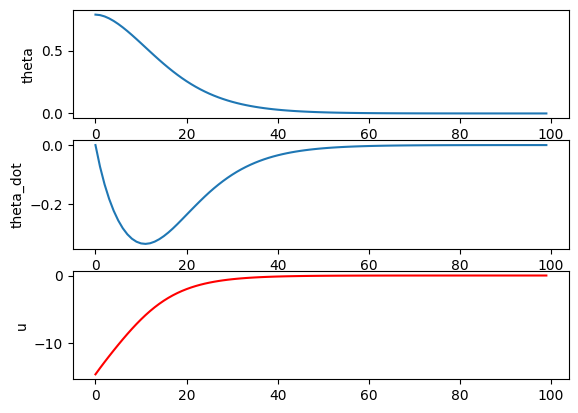

In [7]:
Q = np.diag([1,2])
R = 1
Klqr, P, eigvals = dlqr(Ad,Bd,Q,R)
t0 = 0
sol = solve_ivp(fun=continuous_dyn_with_controller, t_span=[t0, Tf], t_eval=traj_time,
                y0=x0, method='RK45', vectorized=True, args=(Klqr.flatten(), a0, a1, b0))

u = [-Klqr.dot(sol.y[:, i]) for i in range(len(sol.y[0,:]))]

plt.subplot(3,1,1)
plt.plot(sol.y[0,:])
plt.ylabel('theta')
plt.subplot(3,1,2)
plt.plot(sol.y[1,:])
plt.ylabel('theta_dot')
plt.subplot(3,1,3)
plt.plot(u, 'r')
plt.ylabel('u')
plt.show()

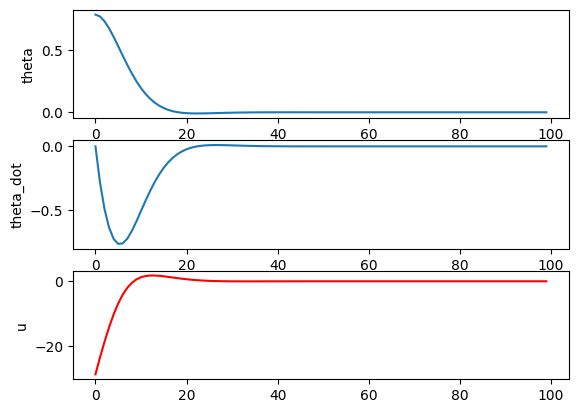

In [8]:
Q = np.diag([1,0])
R = 0.001
Klqr, P, eigvals = dlqr(Ad,Bd,Q,R)
t0 = 0
sol = solve_ivp(fun=continuous_dyn_with_controller, t_span=[t0, Tf], t_eval=traj_time,
                y0=x0, method='RK45', vectorized=True, args=(Klqr.flatten(), a0, a1, b0))

u = [-Klqr.dot(sol.y[:, i]) for i in range(len(sol.y[0,:]))]

plt.subplot(3,1,1)
plt.plot(sol.y[0,:])
plt.ylabel('theta')
plt.subplot(3,1,2)
plt.plot(sol.y[1,:])
plt.ylabel('theta_dot')
plt.subplot(3,1,3)
plt.plot(u, 'r')
plt.ylabel('u')
plt.show()

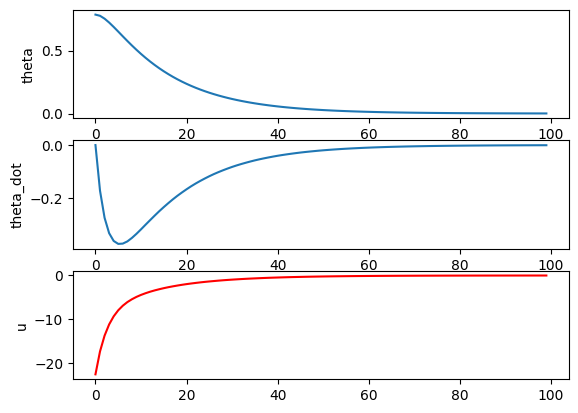

In [9]:
Q = np.diag([1,2])
R = 0.001
Klqr, P, eigvals = dlqr(Ad,Bd,Q,R)
xprev = x0
t0 = 0
sol = solve_ivp(fun=continuous_dyn_with_controller, t_span=[t0, Tf], t_eval=traj_time,
                y0=x0, method='RK45', vectorized=True, args=(Klqr.flatten(), a0, a1, b0))

u = [-Klqr.dot(sol.y[:, i]) for i in range(len(sol.y[0,:]))]

plt.subplot(3,1,1)
plt.plot(sol.y[0,:])
plt.ylabel('theta')
plt.subplot(3,1,2)
plt.plot(sol.y[1,:])
plt.ylabel('theta_dot')
plt.subplot(3,1,3)
plt.plot(u, 'r')
plt.ylabel('u')
plt.show()